<a href="https://colab.research.google.com/github/wayoo2019/DS-Capstone-Projects/blob/main/Amazon_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 2 Model Creation and Prediction

DSC 483 Capstone Mini Project

*   Yuan Wang
*   Shijing Li





In [2]:
# mount Google Drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load the regular expression library
import re
# Import the wordcloud library
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# %%time
# amazon = pd.read_csv("/content/drive/MyDrive/Mini Project/amazon_reviews.csv")
# submission = pd.read_csv("/content/drive/MyDrive/Mini Project/sampleSubmission.csv")

CPU times: user 23.6 ms, sys: 6.02 ms, total: 29.6 ms
Wall time: 475 ms


In [21]:
# Import After processed data to save time 
%%time
amazon = pd.read_parquet("/content/drive/MyDrive/Mini Project/amazon_reviews4.parquet.gzip")
submission = pd.read_csv("/content/drive/MyDrive/Mini Project/sampleSubmission.csv")

CPU times: user 12 s, sys: 7.76 s, total: 19.8 s
Wall time: 7.84 s


#### 2.1 non-Text part feature engineering



*   Convert delta time to datetime and parse Day, Month, Week, Year 
*   Calculate varaibles' length and help ratio
*   Missing value imputation
*   Count userID for review times






In [ ]:
# Convert delta time to datetime and parse Day, Month, Week, Year
startdate = datetime.datetime.strptime('1970-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
amazon['Time'] = amazon['Time'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
amazon["Day"] = amazon["Time"].dt.day
amazon["Weekday"] = amazon["Time"].dt.weekday
amazon["Month"] = amazon["Time"].dt.month
amazon["Year"] = amazon["Time"].dt.year

In [ ]:
# Calculate varaibles' length and help ratio
amazon['Title_len'] = amazon['ProfileName'].str.len()
amazon['Summary_len'] = amazon['Summary'].str.len()
amazon['Helpful_ratio'] = amazon['HelpfulnessNumerator'] / amazon['HelpfulnessDenominator']
amazon['Review_len'] = amazon['Text'].str.len()

In [ ]:
# Check missing values
amazon.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
Title_len                  0
Summary_len                0
Helpful_ratio              0
Review_len                 0
UserId_count               0
ProductId_count            0
Day                        0
Weekday                    0
Month                      0
Year                       0
dtype: int64

In [ ]:
# Missing value imputation
amazon['Helpful_ratio'].loc[amazon['Helpful_ratio'].isnull()] = -1
amazon['Summary_len'].loc[amazon['Summary_len'].isnull()] = 0
amazon['Title_len'].loc[amazon['Title_len'].isnull()] = 0

In [ ]:
# Count userID for review times
amazon['UserId_count'] = amazon['UserId'].map(amazon['UserId'].value_counts(dropna=False))
amazon['ProductId_count'] = amazon['ProductId'].map(amazon['ProductId'].value_counts(dropna=False))


In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
amazon['UserId'] = le.fit_transform(amazon['UserId'])
amazon['ProductId'] = le.fit_transform(amazon['ProductId'])


####2.2 Clean Text data (Summary + Text = Review)

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download("stopwords")
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))


def tweet_cleaner(x):
  # lower case
  x = x.lower()
  # remove stop words
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  # remove emoji
  x = x.encode(encoding="ascii", errors="ignore").decode()
  # remove hashtags
  x = re.sub("#\S+", " ", x)
  # remove mentions
  x = re.sub("@\S+", " ", x)
  # remove URL/links
  x = re.sub("https*\S+", " ", x)
  #remove punctuation
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  # remove overspaces
  x = re.sub('\s{2,}', " ", x)
  # remove ticks
  x = re.sub("\'\w+", '', x)
  # remove words shorter than 3
  x = re.sub(r'\b\w{1,2}\b', '', x)
  # decontracred phrase
  
  
  return x

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# compute clean data for text
amazon['Text_clean'] = amazon.Text.apply(lemmatize_tweet)

In [ ]:
# compute clean data for summary
amazon['Summary_clean'] = amazon.Summary.astype(str).apply(lemmatize_tweet)

In [ ]:
# combine Summary + Text as Review_clean for text mining
amazon['Review_clean']= amazon['Summary_clean'] + ' '+ amazon['Text_clean']

####2.3 Text Sentiment polarity analysis

In [ ]:
# add sentiment anaylsis columns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
amazon["sentiments"] = amazon["Review_clean"].apply(lambda x: sid.polarity_scores(x))
amazon = pd.concat([amazon.drop(['sentiments'], axis=1), amazon['sentiments'].apply(pd.Series)], axis=1)

Check the correlation between Variables. The new created polarity variables are correlated with prediction target (Score)

In [ ]:
amazon.select_dtypes('number').columns

Index(['Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score',
       'Title_len', 'Summary_len', 'Helpful_ratio', 'Review_len',
       'UserId_count', 'ProductId_count', 'Day', 'Weekday', 'Month', 'Year',
       'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [36]:
corr_list = ['Score','Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 
       'Title_len', 'Summary_len', 'Helpful_ratio', 'Review_len',
       'UserId_count', 'ProductId_count', 'Day', 'Weekday', 'Month', 'Year',
       'neg', 'neu', 'pos', 'compound', 'UserId', 'ProductId', 'Year-Month']

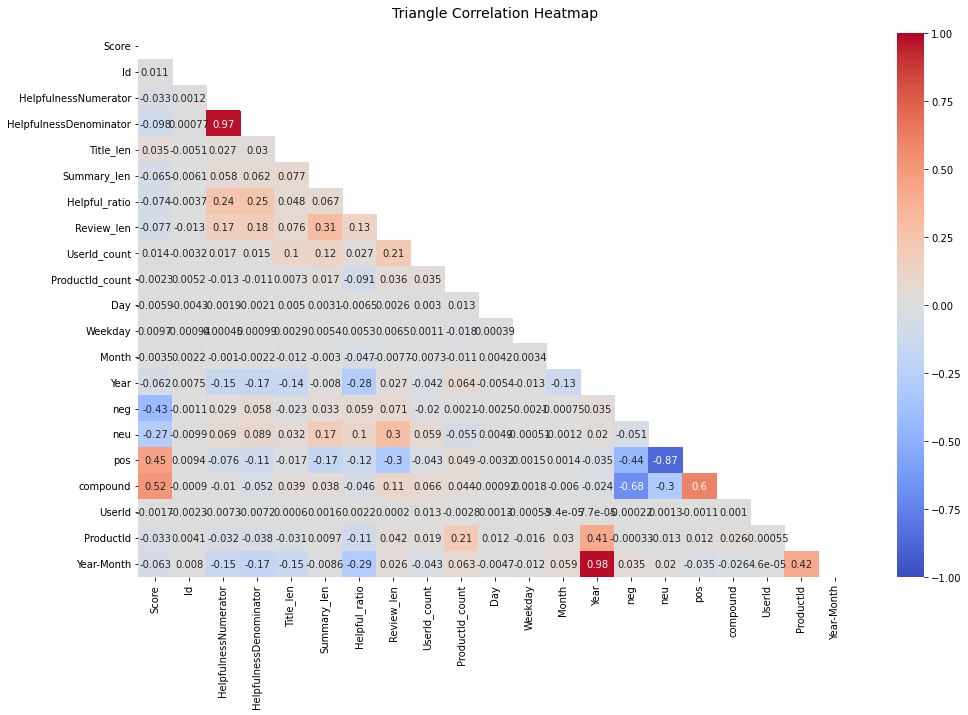

In [37]:
# Create Correlation heatmap
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(amazon[corr_list].corr(), dtype=np.bool))
heatmap = sns.heatmap(amazon[corr_list].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=16);

#### 2.4 Convert text to vector by Dec2Vec

In [ ]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(amazon["Review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4) # choose vector size = 50

# transform each document into a vector data
doc2vec_df = amazon["Review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
amazon = pd.concat([amazon, doc2vec_df], axis=1)

In [ ]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       ...
       'doc2vec_vector_90', 'doc2vec_vector_91', 'doc2vec_vector_92',
       'doc2vec_vector_93', 'doc2vec_vector_94', 'doc2vec_vector_95',
       'doc2vec_vector_96', 'doc2vec_vector_97', 'doc2vec_vector_98',
       'doc2vec_vector_99'],
      dtype='object', length=127)

In [62]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       ...
       'word_two', 'word_use', 'word_want', 'word_water', 'word_way',
       'word_well', 'word_without', 'word_work', 'word_would', 'word_year'],
      dtype='object', length=247)

#### 2.5 Convert Text to TF-IDFS vector

In [ ]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.50, min_df=0.05, ngram_range=(1,2)) 
tfidf_result = tfidf.fit_transform(amazon['Review_clean']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = amazon.index
amazon = pd.concat([amazon, tfidf_df], axis=1)

In [ ]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       ...
       'word_two', 'word_use', 'word_want', 'word_water', 'word_way',
       'word_well', 'word_without', 'word_work', 'word_would', 'word_year'],
      dtype='object', length=247)

#### 2.6 Prediction Model selection

In [38]:
# Create feature list for prediction, numerical feature only
feature_list = amazon.select_dtypes('number').columns.tolist()
feature_list.remove('Score')

len(feature_list)

240

In [39]:
# split train and test data accordingly
train = amazon.loc[amazon['Id'].isin(submission['Id'])==False]
test = amazon.loc[amazon['Id'].isin(submission['Id'])]

In [40]:
# Initial models performance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit

lr = LinearRegression()
rdg = Ridge()
las = Lasso()


def model_score(X, y):
  Classifiers = ['Linear regression','Ridge regression','Lasso regression']
  scores = []
  models = [lr, rdg, las]

  cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

  for model in models:
    score = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=cv_split).mean()
    scores.append(score)

  results = pd.DataFrame(scores, index=Classifiers, columns=["Score"]).sort_values(by = 'Score', ascending = False)

  print(results)

model_score(train[feature_list], train['Score'])

                      Score
Ridge regression  -0.938207
Linear regression -0.938222
Lasso regression  -1.304367


It looks that Linear regression and Ridge regression got the better RMSE result

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(train[feature_list], train['Score'], test_size=0.33, random_state=42)
# pipeline = Pipeline([
#                      ('scaler',StandardScaler()),
#                      ('model',Lasso())
# ])
# search = GridSearchCV(pipeline,
#                       {'model__alpha':np.arange(0.1,10,0.1)},
#                       cv = 5, scoring="neg_mean_squared_error",verbose=3
#                       )
# search.fit(X_train,y_train)

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = train[feature_list]
y = train['Score']


lr = LinearRegression()
scores = -cross_val_score(lr, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
scores

0.9397581885235446

####2.7 Feature reduction (RFE)

In [48]:
from sklearn.feature_selection import RFE
# final model
n_features_optimal = len(feature_list)

X = train[feature_list]
y = train['Score']

lm = LinearRegression()
lm.fit(X, y)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X, y)

# predict prices of X_test
y_pred = lm.predict(test[feature_list])
mse = metrics.mean_squared_error(test['Score'], y_pred)
mse

0.8944641021229289

In [57]:
len(feature_list)

240

In [52]:
X.columns[rfe.support_]

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Title_len', 'Summary_len', 'Helpful_ratio',
       'Review_len', 'UserId_count',
       ...
       'word_use', 'word_want', 'word_water', 'word_way', 'word_well',
       'word_without', 'word_work', 'word_would', 'word_year', 'Year-Month'],
      dtype='object', length=240)

In [ ]:
feature_select = pd.DataFrame()
feature_select["Features"] = X.columns
feature_select['Select'] =  rfe.support_
feature_select

,Features,Select
0,Id,True
1,HelpfulnessNumerator,True
2,HelpfulnessDenominator,True
3,Title_len,True
4,Summary_len,True
...,...,...
232,word_well,True
233,word_without,True
234,word_work,True
235,word_would,True


#### 2.8 Final RMSE  & Confusion Matrix for test data set

RMSE for test data set

In [233]:
# round the decimal and conver value < 0 to rate 1
test['Predicted'] = y_pred
test['Predicted'].loc[test['Predicted'] < 1] = 1
test['Predicted'].loc[test['Predicted'] > 4] = 5
test['Predicted'] = test['Predicted'].round().astype(int)
sub = test[['Id', 'Predicted']]
sub['Predicted'] = test['Predicted']

from math import floor, ceil
metrics.mean_squared_error(test['Score'], sub['Predicted'])

0.91641

Confusion Matrix for test data set

In [234]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
cm_df = pd.DataFrame(confusion_matrix(test['Score'], sub['Predicted']))
cm_df

,0,1,2,3,4
0,1139,2774,3717,1224,493
1,178,848,2295,1244,638
2,87,592,2452,2161,2040
3,23,244,1680,3095,9151
4,32,259,2423,6094,55117


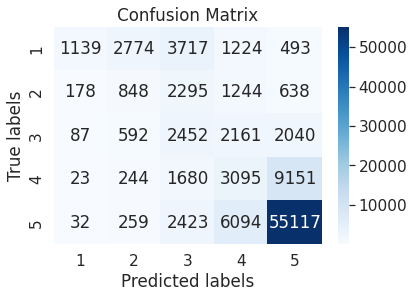

In [235]:
ax= plt.subplot()
sns.heatmap(cm_df, annot=True, fmt='g', ax=ax, cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5']);

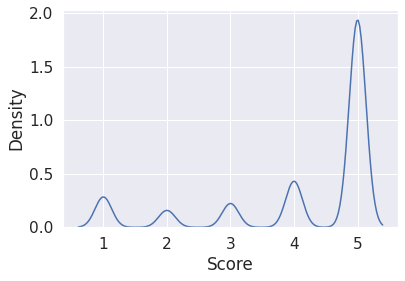

In [231]:
sns.kdeplot(test['Score'])

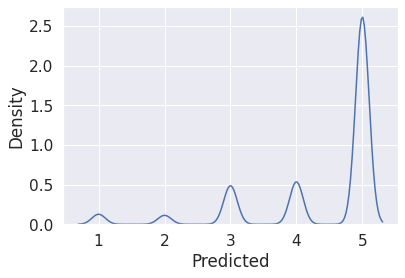

In [232]:
sns.kdeplot(test['Predicted'])

In [170]:
sub.head(3)

,Id,Predicted
8,9,5
9,10,5
15,16,4


In [169]:
sub.to_csv('sub.csv', index=False)
!cp sub.csv "/content/drive/MyDrive/Mini Project/"

In [56]:
amazon.to_parquet('amazon_reviews5.parquet.gzip', compression="gzip")
!cp amazon_reviews5.parquet.gzip "/content/drive/MyDrive/Mini Project/"